<a href="https://colab.research.google.com/github/DoryAbelman/CARTE-ML-Program/blob/main/labs/lab-1-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Day 1: Introduction to Machine Learning with Python
## Lab 1-2: Decision Trees and Random Forests

In the first lab, we used a decision tree classifier to evaluate the quality of different imputation methods, but we didn't really discuss what decision trees are or how they work. In this lab, we will delve into the details of decision trees and explore how they can be used to predict the survival of Titanic passengers.

In [1]:
# Install xgboost and graphviz, which we will use later in the lab
!pip install -U xgboost graphviz

### Decision Trees

Decision trees are popular supervised learning methods used for classification and regression. The tree represents a series of simple decision rules that predict the target when the feature vector is passed through them. Decision trees are easy to understand, can be visualized nicely, require very little data preparation (e.g., we don't need to scale features), and the trained model can be explained easily to others post priori (as opposed to other *black box* methods that are difficult to communicate).

###### Example
Suppose you wanted to design a simple decision tree for whether (or not) you buy a used car. You might develop something like the following:

<img src="https://github.com/lyeskhalil/mlbootcamp/blob/master/img/decision-tree.gif?raw=1" width="500"/>

**YOUR TURN:** Let's say you're browsing Kijiji and come across a used car that: has been road tested, has high mileage, and is a recent year/model.
* According to your decision tree model, should you buy this car or not? ____________________________
* Will you buy any cars that haven't been road tested (if you follow your model)? ___________________________________

Obviously this tree may not be ideal, depending on the situation. For example, you could have a road tested car of a recent year with 2,000,000 km's on it and the model is telling you to buy! (But, you probably shouldn't)

### Titanic Dataset

Just as in the first lab, we are going to use the Titanic dataset to predict passenger survival. Let's start by loading the data and doing some exploratory data analysis (EDA).

In [2]:
import pandas as pd # import pandas to get access to dataframe operations
from sklearn.datasets import fetch_openml # import function to retrieve relevant datasets

full_data = fetch_openml("titanic", version=1, as_frame=True) # Get all data and metadata
data = full_data.frame # Extract the relevant data
data.survived = pd.to_numeric(data['survived'])
data.drop(['boat', 'body', 'home.dest'], axis=1, inplace=True) # Drop irrelevant columns
data.head() # view the first 5 rows

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1.0,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S
1,1.0,1,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S
2,1.0,0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S
3,1.0,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,C22 C26,S
4,1.0,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,C22 C26,S


As we have seen already, we can use Pandas to conveniently summarize key aspects of the dataset such as the number of passengers, features, survived/didn't, and their gender. We are also able to identify the number of missing values per feature in the dataset.

To accomplish this, we used Pandas flexible indexing capability. The syntax `data[data[col]==val]` allows us to return the subset of rows in `data` where column `col` takes on value `val`. Very powerful!

As you may have suspected, the dataset we're using is actually a subset of the total Titanic data. In reality, there were actually 3,547 passengers while the data we're working with only concerns 1309 of them.

**YOUR TURN:**
Using similar syntax, answer the following questions about the data:
* In the dataset, what is the passenger survival rate? ____________________________
* How many passengers paid more than $10 for fare? ____________________________
* How many passengers had a passenger class (Pclass) of 3? ________________________
* With some discussion/exploration and try to determine what features might be the most relevant to passenger survival.

In [13]:
# prompt:

# In the dataset, what is the passenger survival rate?
survival_rate = data.survived.mean()
print(f"The passenger survival rate is: {survival_rate}")

# How many passengers paid more than $10 for fare?
passengers_paid_more_than_10 = data[data.fare > 10].shape[0]
print(f"Number of passengers who paid more than $10 for fare: {passengers_paid_more_than_10}")

# How many passengers had a passenger class (Pclass) of 3?
passengers_with_pclass_3 = data[data.pclass == 3].shape[0]
print(f"Number of passengers with Pclass 3: {passengers_with_pclass_3}")

# With some discussion/exploration and try to determine what features might be the most relevant to passenger survival.
# Possible features that might be relevant to passenger survival:
# - sex
# - age
# - pclass
# - fare
# - cabin
# - embarked
# - title (e.g., Mr., Mrs., Miss)
# - family size
# - alone (whether the passenger was traveling alone or not)



The passenger survival rate is: 0.3819709702062643
Number of passengers who paid more than $10 for fare: 817
Number of passengers with Pclass 3: 709


In [34]:
## Your code here

## Survival rate
survival_rate = len(data[data['survived'].astype(int) == 1]) / len(data)
print(survival_rate)

## Paid rate
#paid_rate = len(data[data['fare'].astype(int) > 10]) / len(data)
print(survival_rate)

##

0.3819709702062643
0.3819709702062643


### Preparing the Data

Just like in the first lab, we are going to prepare the data for our decision tree model. This involves encoding categorical values as numbers, dropping non-numeric columns, and splitting the data into training and test sets.

In [14]:
data = data.drop(['name', 'ticket', 'cabin'], axis=1) # remove non-numeric columns

data = pd.get_dummies(data, columns=['sex', 'embarked'], drop_first=True) # encode categorical values as numbers

data

,pclass,survived,age,sibsp,parch,fare,sex_male,embarked_Q,embarked_S
0,1.0,1,29.0000,0.0,0.0,211.3375,False,False,True
1,1.0,1,0.9167,1.0,2.0,151.5500,True,False,True
2,1.0,0,2.0000,1.0,2.0,151.5500,False,False,True
3,1.0,0,30.0000,1.0,2.0,151.5500,True,False,True
4,1.0,0,25.0000,1.0,2.0,151.5500,False,False,True
...,...,...,...,...,...,...,...,...,...
1304,3.0,0,14.5000,1.0,0.0,14.4542,False,False,False
1305,3.0,0,NaN,1.0,0.0,14.4542,False,False,False
1306,3.0,0,26.5000,0.0,0.0,7.2250,True,False,False
1307,3.0,0,27.0000,0.0,0.0,7.2250,True,False,False


In the above cell, we dropped the non-numeric categories which are a little harder to deal with. Then we used the `pd.get_dummies` function to replace our categorical variables with numeric ones. Note that in the first lab, we alluded to the fact that we can actually get away with n-1 columns for n categories. This is because a value of False for all n-1 columns implies the nth value is True. While this isn't too important one way or the other for our small toy dataset, you can imagine that for a significantly larger dataset, this could save a lot of memory.

##### Model Development

OK! Let's get to developing some decision tree models to predict passenger survival. We will start with simple decision trees and develop more complex models from there. Our first step, as in previous labs, is to split our data into a training set and a test set (unseen data). We will then use k-folds cross validation on the training set to try and get the best performing model before finally applying it to the test data.

Let's import sklearn's decision tree classifer and split the data (using techniques we covered in the first lab).

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

target_data = data["survived"]
feature_data = data.iloc[:, data.columns != "survived"]

X_train, X_test, y_train, y_test = train_test_split(feature_data, target_data, test_size=0.3, random_state=0)

**YOUR TURN:**
* How many samples are in the training set? _______________________
* How many samples are in the test set? _______________________
* What are the survival rates in each of the datasets? ______________________

In [18]:
# How many samples are in the training set?
train_samples = len(X_train)
print(f"Number of samples in training set: {train_samples}")

# How many samples are in the test set?
test_samples = len(X_test)
print(f"Number of samples in test set: {test_samples}")

# What are the survival rates in each of the datasets?
train_survival_rate = y_train.mean()
test_survival_rate = y_test.mean()
print(f"Survival rate in training set: {train_survival_rate}")
print(f"Survival rate in test set: {test_survival_rate}")



Number of samples in training set: 916
Number of samples in test set: 393
Survival rate in training set: 0.3853711790393013
Survival rate in test set: 0.37404580152671757


In [ ]:
## Your code here
##
##
##

##### Dealing with Missing Data: Imputation

Before we can fit our decision tree to our training data, we can conduct imputation to replace missing values in our dataset. Previously we did this manually so that we could follow the process, but now we'll use the handy `SimpleImputer` class from sklearn. This class allows us to replace missing values with a specified strategy (e.g., mean, median, most frequent).

In [24]:
from sklearn.impute import SimpleImputer
import numpy as np

imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

imp.fit(X_train)
X_train = imp.transform(X_train) # replace missing data using our imputer
X_test = imp.transform(X_test) # replace missing data using our imputer on the test data that we trained on the train data

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


So we've got our data prepared, let's fit a decision tree to our training data.

In [25]:
from sklearn.metrics import accuracy_score
from sklearn import tree

clf = tree.DecisionTreeClassifier()

clf.fit(X_train, y_train)

accuracy = accuracy_score(y_train, clf.predict(X_train))
print ("Accuracy: ", accuracy * 100, "%")

Accuracy:  97.48908296943232 %


In the above cell, we defined a Decision Tree classifier and fit it to our training set. When we then used it to predict training set values, the resulting accuracy was ~97%.

**YOUR TURN:**
* Since we are both training and predicting on our training set, why didn't the decision tree achieve 100% accuracy?
* What is the performance of this model on the test set?


In [26]:
# Since we are both training and predicting on our training set, why didn't the decision tree achieve 100% accuracy?
# The decision tree did not achieve 100% accuracy because it is not possible to perfectly fit a decision tree to any dataset. There will always be some data points that are misclassified.

# What is the performance of this model on the test set?
accuracy = accuracy_score(y_train, clf.predict(X_train))
print ("Accuracy: ", accuracy * 100, "%")
accuracy = accuracy_score(y_test, clf.predict(X_test))
print("Accuracy on test set:", accuracy * 100, "%")



Accuracy:  97.48908296943232 %
Accuracy on test set: 75.57251908396947 %


In [ ]:
## Your code here
##
##
##

##### Feature Importances

One thing we can do is take a look at the relative feature importances of the trained decision tree classifier. This will give us an idea of what the model thinks is more/less important for properly predicting the target.

Let's look at the feature importances for a model on the training data:

In [27]:
for feature, importance in zip(data.columns.drop('survived'), clf.feature_importances_):
    print(f'{feature:15}{importance:.4f}')

pclass         0.1039
age            0.2286
sibsp          0.0502
parch          0.0109
fare           0.2725
sex_male       0.3070
embarked_Q     0.0078
embarked_S     0.0191


As we can see, the tree is placing a higher importance on Sex, Age, and Fare paid. These are interesting observations that we could dig a little deeper into if we wanted to.

#### Visualizing the Tree

One useful thing we can do is actually visualize our decision tree model! We can use the [graphViz](https://www.graphviz.org/) library to accomplish this:

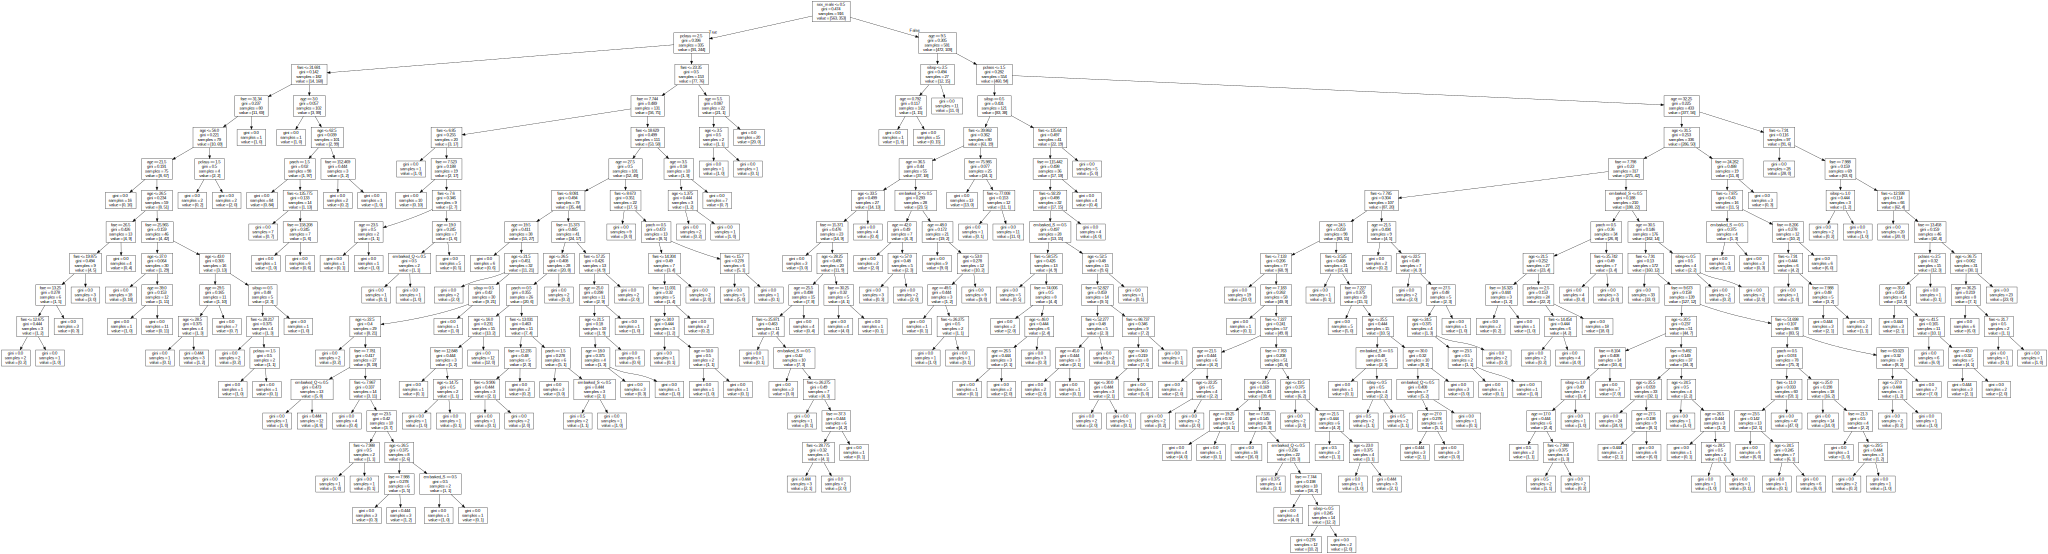

In [28]:
from sklearn.tree import export_graphviz
import graphviz # Package containing visualization tools

export_graphviz(clf, out_file="mytree.dot", feature_names=data.columns.drop('survived')) # Save the visualization of the tree
with open("mytree.dot") as f: # read the file back in
    dot_graph = f.read()
graphviz.Source(dot_graph) # display the tree

**YOUR TURN:** Explore the decision tree and answer the following:
* What feature does the root node split on?
* What is the depth of the decision tree (i.e., the length of the longest path from root to leaf)?
* Do you think this decision tree is prone to overfitting? Why/why not?

To reduce the degree to which this tree is overfit to the training data, we can force the tree to be of some *maximum depth*. This ensures the tree won't be able to just keep generating new layers to properly classify every sample in the training stage (and, thus, presumably generalize better to the test set).

Let's try limiting the max depth to 2 and visualizing the resulting tree.

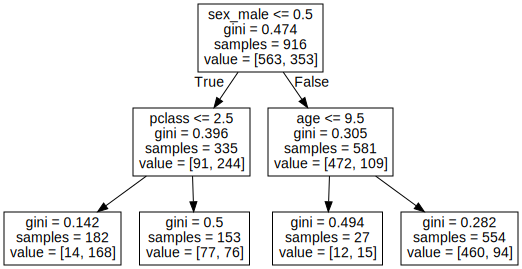

In [29]:
clf = tree.DecisionTreeClassifier(max_depth = 2)

clf.fit(X_train, y_train)

export_graphviz(clf, out_file="mytree.dot", feature_names=data.columns.drop('survived'))
with open("mytree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

Much simpler! As we can see, our model finds Age, Sex, and Pclass to be the most important features. We would expect this model to have much poorer performance when predicting on the training set (as opposed to our 97% we got above), but perhaps better performance on unseen data.

There are many hyper-parameters that can be tuned to change how the model performs. Some common parameters that are modified include:
1. Max Tree Depth: How "tall" do you want your tree to be
2. Minimum Samples Per Leaf: This parameter defines the minimum number of training datapoints that fall into a given leaf node in order for that node to be created
3. Minimum Samples to Split: This parameter controls the minimum number of samples required to create a decision split

To decide the values of each of the parameters, we can use Grid Search combined with cross validation. In Grid Search, we first decide what potential values we want each hyperparameter will take. Then we find every possible combination of parameters and run cross validation on each combination to estimate the performance of that hyperparameter combination.

Luckily, `sklearn` has a nice implementation of Grid Search that runs this algorithm for us. Lets see a demo below:

In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

clf = tree.DecisionTreeClassifier() # First we define our model without passing in parameters
hyperparameter_search = { # Then we decide the possible parameter combinations
    'max_depth': [2, 3, 4, 5],
    'min_samples_split': [2, 5, 8, 11],
    'min_samples_leaf': [2, 5, 8, 11]
} # Since we have 3 parameters with 2 possible values, grid search will test 3^3 combinations
evaluation_metric = make_scorer(accuracy_score, # GridSearchCV requires us to wrap our metric function in a "scorer"
                                greater_is_better = True)

grid_search_cv = GridSearchCV(estimator = clf,
                              param_grid = hyperparameter_search,
                              scoring = evaluation_metric,
                              cv = 5) # Set up search algorithm
grid_search_cv.fit(X_train, y_train) # Run the search. NOTE: This may take a while

print("Best Parameters: ", grid_search_cv.best_params_) # Print the parameters
print ("Best CV Accuracy: ", grid_search_cv.best_score_ * 100, "%")

clf = grid_search_cv.best_estimator_ # Get the best model from the GridSearch
accuracy = accuracy_score(y_test, clf.predict(imp.transform(X_test)))
print ("Testing Accuracy: ", accuracy * 100, "%") # Print the testing accuracy of the best model

Best Parameters:  {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best CV Accuracy:  81.54906153480637 %
Testing Accuracy:  81.1704834605598 %


In the cell above, we tested our two values per hyperparameter and ran grid search to find the best combination from the space we defined. As you may have noticed, the number of combinations tested by Grid Search exponentially increases as you test more values and tune more hyperparameters. This means that performing a grid search is often a task that takes a long period of time and is often note used for more complex models like neural networks.

### Random Forests, Gradient Boosting, Extreme Gradient Boosting

Let's (briefly) investigate some more advanced tree models that you have learned about and see if we can improve our performance. We will be using the following models in addition to our decision tree classifier:

* Scikitlearn Random Forest classifier
* Scikitlearn Gradient boosting classifier
* XGBoost classifier

Note that XGBoost is similar in theory to Scikitlearn's Gradient boosting classifier. However, XGBoost's implementation is highly efficient than that of Scikitlearn's. Forests are *ensemble* techniques that combine multiple decision trees. As you learned in lecture, and as visualized below, random forest methods usually combine multiple trees through some sort of voting scheme.

<img src="https://github.com/lyeskhalil/mlbootcamp/blob/master/img/random-forest.png?raw=1" width="400"/>

In the above example, two trees vote (predict) Class B and another predicts Class A, so the overall ensemble vote goes to the majority (Class B). Boosting, on the other hand, uses multiple trees in in a stage-wise fashion. Popular machine learning software XGBoost has a great explanation for [how this works](https://xgboost.readthedocs.io/en/latest/tutorials/model.html).

Let's build some ensemble classifiers!

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

Now, let's see how they perform!

In [32]:
clf = tree.DecisionTreeClassifier()
clf_random = RandomForestClassifier()
clf_gradient = GradientBoostingClassifier()
clf_xgb = XGBClassifier()

scores = cross_val_score(clf, X_train, y_train, cv=5)
scores_random = cross_val_score(clf_random, X_train, y_train, cv=5)
scores_gradient = cross_val_score(clf_gradient, X_train, y_train, cv=5)
scores_xgb = cross_val_score(clf_xgb, X_train, y_train, cv=5)

print("Decision tree accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print("Random forest accuracy: %0.2f (+/- %0.2f)" % (scores_random.mean(), scores_random.std() * 2))
print("Gradient boosting accuracy: %0.2f (+/- %0.2f)" % (scores_gradient.mean(), scores_gradient.std() * 2))
print("XGBoost accuracy: %0.2f (+/- %0.2f)" % (scores_xgb.mean(), scores_xgb.std() * 2))

Decision tree accuracy: 0.77 (+/- 0.04)
Random forest accuracy: 0.79 (+/- 0.05)
Gradient boosting accuracy: 0.81 (+/- 0.04)
XGBoost accuracy: 0.79 (+/- 0.06)


We can see that each of the more sophisticated tree/forest methods improves upon the initial decision tree accuracy in terms of cross-validated accuracy.

Let's see how the extreme gradient boosted method performs on the hold-out test set.

In [33]:
from sklearn.metrics import accuracy_score

imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

imp.fit(X_test)
X_test = imp.transform(X_test)

clf_xgb.fit(X_train, y_train)
accuracy = accuracy_score(y_test, clf_xgb.predict(X_test))

print ("Test set accuracy: ", accuracy * 100, "%")

Test set accuracy:  80.1526717557252 %


First, we imputed the missing values in the test set (as we had done for the training set) and then we applied our gradient boosting-based classifier (as trained on the training data). We yielded an 81% accuracy; not bad!

**YOUR TURN:**
* What features did the gradient boosting algorithm find the most important? __________________
* What is the test set accuracy if, instead, you used the Scikitlearn's gradient boosting algorithm? __________________

* If you designed a naive classifier that simply guessed 'did not survive' (i.e., Survived = 0) for every row in the test set, how would it perform? ________________________
* Is this better or worse than our gradient boosted tree? ____________________________

In [37]:
# What features did the gradient boosting algorithm find the most important?
importances = clf_xgb.feature_importances_
features = data.columns.drop('survived')

for i, feature in enumerate(features):
  print(f"{feature}: {importances[i]}")

# What is the test set accuracy if, instead, you used the Scikitlearn's gradient boosting algorithm?
clf_gradient = GradientBoostingClassifier()
clf_gradient.fit(X_train, y_train)
accuracy = accuracy_score(y_test, clf_gradient.predict(X_test))
print(f"Test set accuracy with Scikitlearn's gradient boosting algorithm: {accuracy * 100:.2f}%")

# If you designed a naive classifier that simply guessed 'did not survive' (i.e., Survived = 0) for every row in the test set, how would it perform?
naive_accuracy = len(data[data['survived'] == 0]) / len(data) * 100
print(f"Naive classifier accuracy: {naive_accuracy:.2f}%")

# Is this better or worse than our gradient boosted tree?
if accuracy > naive_accuracy:
  print("Gradient boosted tree is better than the naive classifier.")
else:
  print("Naive classifier is better than the gradient boosted tree.")


pclass: 0.17698761820793152
age: 0.03234889730811119
sibsp: 0.0688021183013916
parch: 0.024394415318965912
fare: 0.03725177422165871
sex_male: 0.5691613554954529
embarked_Q: 0.048052024096250534
embarked_S: 0.04300188645720482
Test set accuracy with Scikitlearn's gradient boosting algorithm: 81.42%
Naive classifier accuracy: 61.80%
Naive classifier is better than the gradient boosted tree.


In [36]:
## Your code here
scores

array([0.76630435, 0.7431694 , 0.7704918 , 0.78688525, 0.80327869])